# Item sales demand forecasting

### Summary

<b> Observations: </b> HERE

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv('data/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Missing Values Imputation

In [3]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Data Preprocessing

In [4]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day

train_df['weekday'] = train_df['date'].dt.weekday
train_df['weekday'] = np.where(train_df.weekday == 0, 7, train_df.weekday)

train_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1729,2017-09-26,1,1,18,2017,9,26,1
1730,2017-09-27,1,1,27,2017,9,27,2
1731,2017-09-28,1,1,23,2017,9,28,3
1732,2017-09-29,1,1,28,2017,9,29,4


In [5]:
test_df

,date,store,item,sales
0,2017-10-01,1,1,21
1,2017-10-02,1,1,12
2,2017-10-03,1,1,18
3,2017-10-04,1,1,15
4,2017-10-05,1,1,20
...,...,...,...,...
87,2017-12-27,1,1,14
88,2017-12-28,1,1,19
89,2017-12-29,1,1,15
90,2017-12-30,1,1,27


### EDA Plots

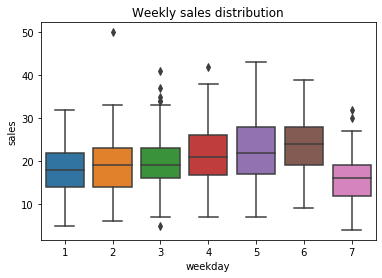

In [6]:
plot = sn.boxplot(x='weekday', y='sales', data=train_df)
_ = plot.set(title='Weekly sales distribution')

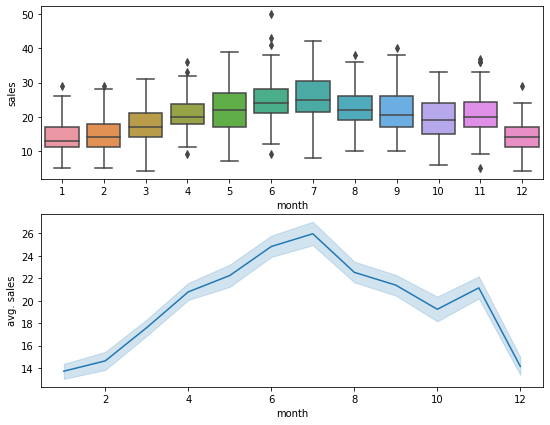

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='month', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

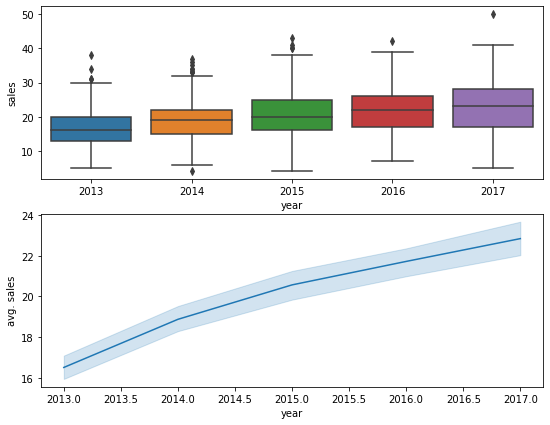

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='year', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

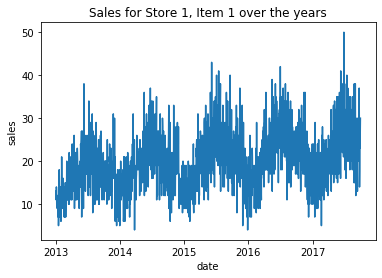

In [9]:
plot = sn.lineplot(x='date', y='sales', data=train_df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

### Baseline Model: Seasonal Naive

In [10]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,seasonal_naive_sales
0,2017-10-01,1,1,25
1,2017-10-02,1,1,26
2,2017-10-03,1,1,20
3,2017-10-04,1,1,28
4,2017-10-05,1,1,17


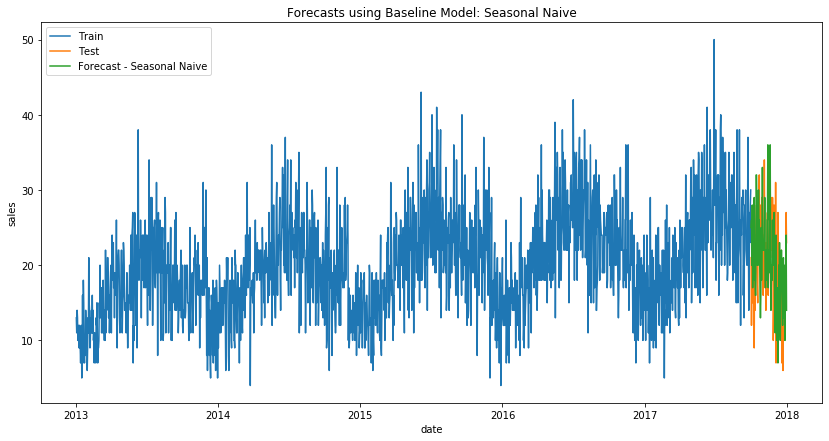

In [11]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

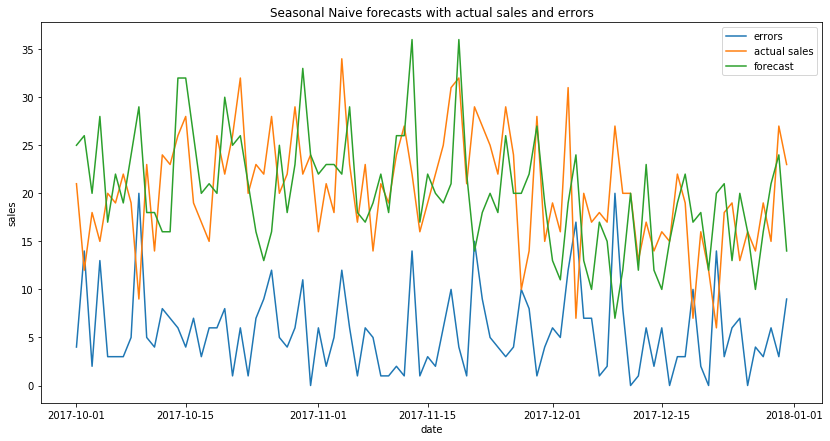

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [12]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

### Time Series Decomposition Plot

<b> Observations: </b> HERE

In [13]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

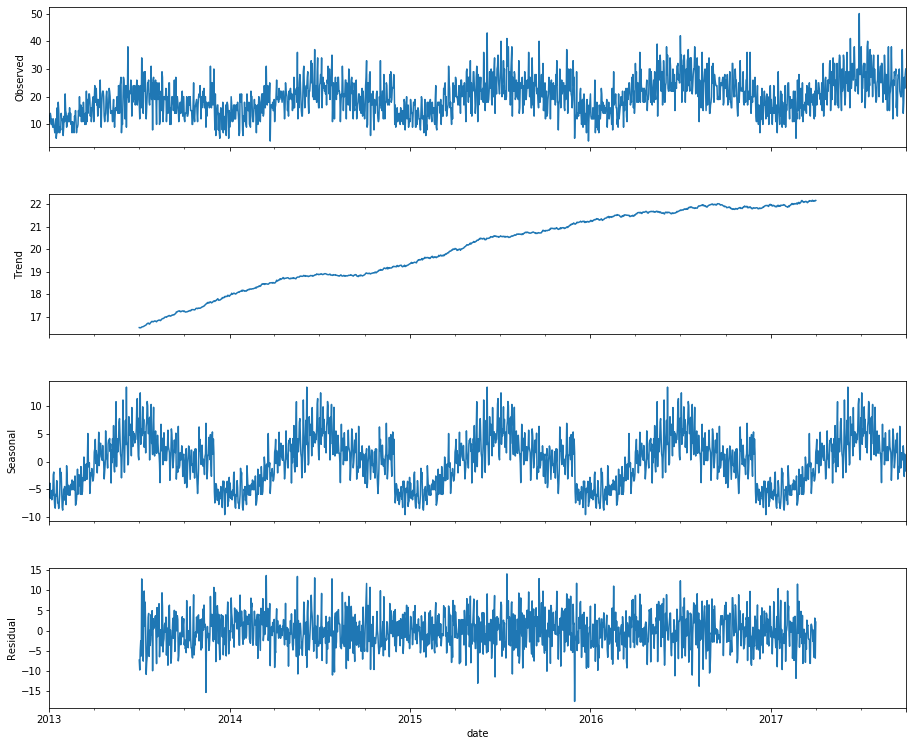

In [14]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

### Holt Winter's Triple Exponential Smoothing Model

In [15]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


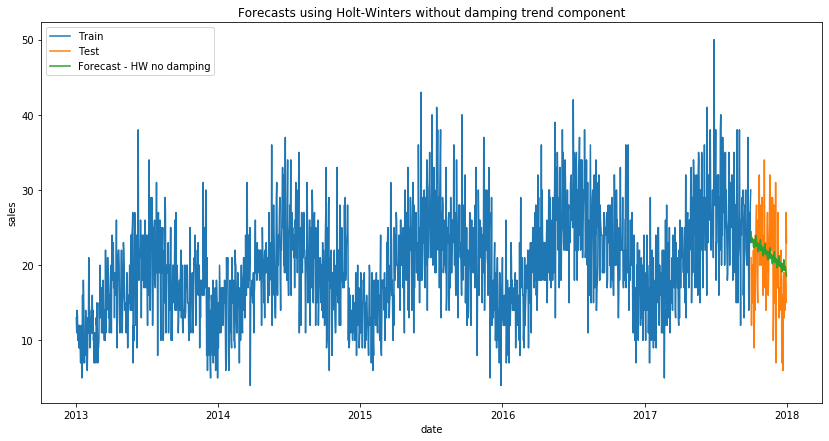

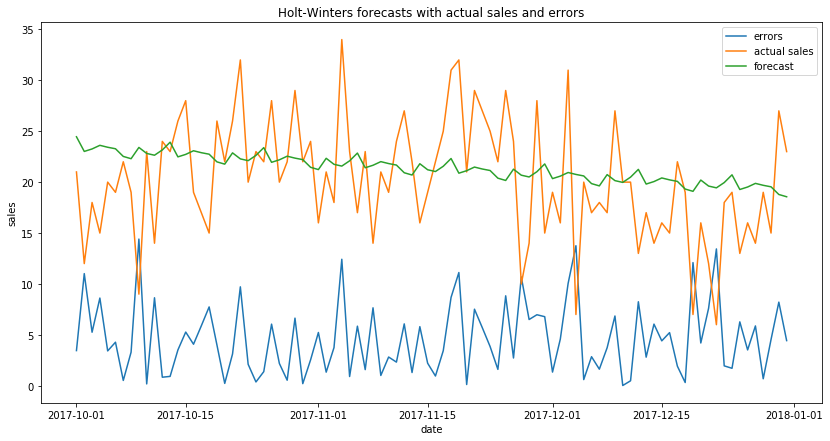

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1861,1966.695466,-105.695466,4.62932,5.827427,22.885408


In [16]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

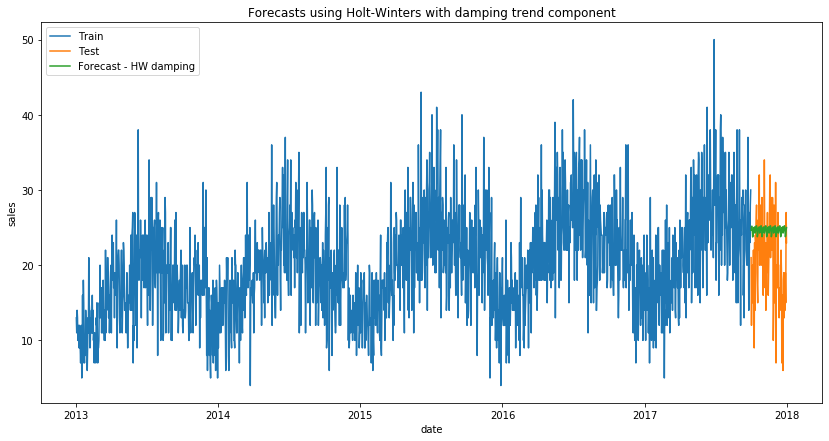

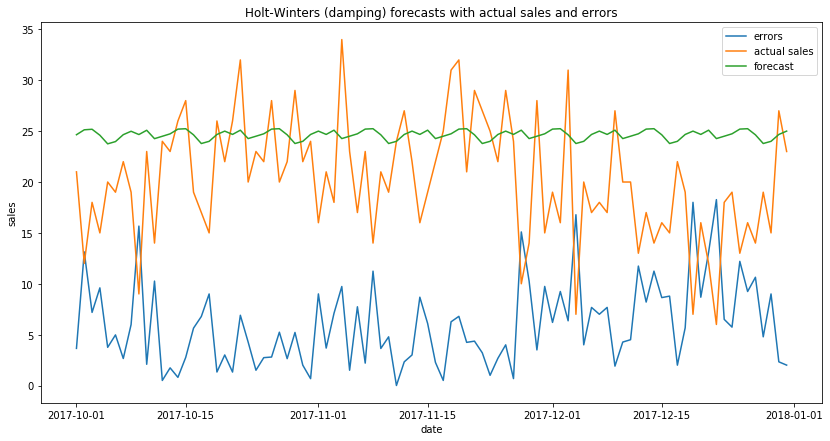

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1861,2267.672189,-406.672189,6.016185,7.319618,29.741486


In [17]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd

### Autoregressive Integrated Moving Average - ARIMA Model

#### Step 1: Check stationarity

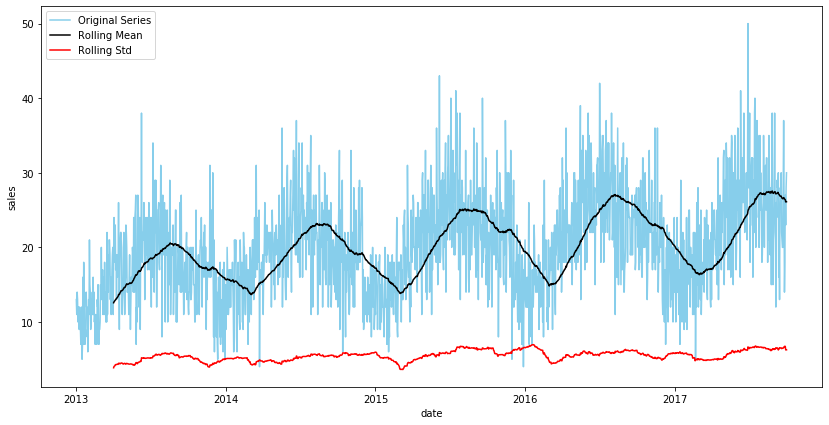

In [66]:
arima_df = train_df[['date', 'sales']].set_index('date')
num_rows, num_cols = test_df.shape

# Plotting rolling statistics
rollmean = arima_df.rolling(window=num_rows).mean()
rollstd = arima_df.rolling(window=num_rows).std()

plt.figure(figsize=(14,7))
plt.plot(arima_df, color='skyblue', label='Original Series')
plt.plot(rollmean, color='black', label='Rolling Mean')
plt.plot(rollstd, color='red', label='Rolling Std')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()